# Lab 6a - K-Medoids

This notebook introduces the K-Medoids Clustering Method, its visualization and spatial analysis.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We illustrate *K-Medoids*. This is a partitioning method, but it is designed for a different objective function than K-Means.

K-Medoids attempts to minimize the sum of distances from the observations in each cluster to a representative center for that cluster. In contrast to what is the case for K-Means, this center is one of the observations. K-Medoids works with any dissimilarity matrix, especially with a distance matrix based on a Manhattan distance metric, which is less affected by outliers.

The empirical illustration uses the examples in Chapter 7 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

As it turns out, K-Medoids clustering is currently not supported by Scikit-learn or Scipy. We therefore have to install the specialized **kmedoids** package (https://python-kmedoids.readthedocs.io/en/latest/). If not already installed, the library can be installed running `pip install kmedoids` from your terminal or notebook.

In addition to the usual geopandas, we also import several specialized packages from scikit-learn. Specifically, to carry out variable standardization we import `StandardScaler` from `sklearn.preprocessing`, and to compute the distance matrix we need `pairwise_distances` from `sklearn.metrics`. Finally, we import `cluster_stats`, `cluster_fit` and `cluster_map` from the `spatial_cluster_course` utility module (this requires that the file spatial_cluster_course.py is in the current Python path).

In [1]:
import geopandas as gpd

import kmedoids

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

from spatial_cluster_course import cluster_stats, cluster_fit, cluster_map

### Load data

To illustrate K-Medoids, we will again use the data set on socio-economic variables for Chicago census tracts contained in the Chicago-SDOH sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Chi-SDOH/

The following files will be used:
- **Chicago_SDOH.shp,shx,dbf,prj**: shape file (four files) for 971 census tracts

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [ ]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
dfs = gpd.read_file(path+"Chi-SDOH/Chi-SDOH.shp")
print(dfs.shape)
dfs.head(3)

(791, 56)


,OBJECTID,Shape_Leng,Shape_Area,TRACTCE10,geoid10,commarea,ChldPvt14,EP_CROWD,EP_UNINSUR,EP_MINRTY,...,ForclRt,EP_MUNIT,EP_GROUPQ,SchHP_Mi,BrownF_Mi,card,cpval,COORD_X,COORD_Y,geometry
0,1,22777.477721,2.119089e+07,842400.0,1.703184e+10,44.0,30.2,2.0,18.6,100.0,...,0.0,6,0.0,0.323962,0.825032,0.0,0.0,1176.183467,1849.533205,"POLYGON ((1177796.742 1847712.428, 1177805.261..."
1,2,16035.054986,8.947394e+06,840300.0,1.703184e+10,59.0,38.9,4.8,25.2,85.9,...,0.0,2,0.0,2.913039,0.833580,0.0,0.0,1161.787888,1882.078567,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
2,3,15186.400644,1.230614e+07,841100.0,1.703184e+10,34.0,40.4,4.9,32.1,95.6,...,0.0,42,0.1,1.534987,0.245875,0.0,0.0,1174.481923,1889.069999,"POLYGON ((1176041.55 1889791.988, 1176042.377 ..."


In [3]:
# the full set of variables
print(list(dfs.columns))

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'TRACTCE10', 'geoid10', 'commarea', 'ChldPvt14', 'EP_CROWD', 'EP_UNINSUR', 'EP_MINRTY', 'Ovr6514P', 'EP_AGE17', 'EP_DISABL', 'EP_NOHSDP', 'EP_LIMENG', 'EP_SNGPNT', 'Pov14', 'EP_PCI', 'Unemp14', 'EP_NOVEH', 'FORCLRISK', 'HealthLit', 'CarC14P', 'CAR', 'NOCAR', 'CTA14P', 'CTA', 'CmTm14', 'Undr514P', 'Wht14P', 'WHT50PCT', 'Wht', 'Blk14P', 'BLCK50PCT', 'Blk', 'Hisp14P', 'HISP50PCT', 'Hisp', 'Pop2014', 'PDENS14', 'MEANMI_07', 'MEANMI_11', 'MEANMI_14', 'FACHANGE', 'PCRIMERT15', 'VCRIMERT15', 'ForclRt', 'EP_MUNIT', 'EP_GROUPQ', 'SchHP_Mi', 'BrownF_Mi', 'card', 'cpval', 'COORD_X', 'COORD_Y', 'geometry']


#### Census tract centroids

As in Section 7.3 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/kmedoids.html), we will use the centroids of the census tracts for our example. This illustrates the similarity of K-Medoids to the solution of an (unweighted) facility location-allocation problem.

We use the GeoPandas `centroid` attribute applied to our geodataframe, then extract the x and y coordinates and add them as new variables. We rescale them by 1000 to keep the distance units manageable.

Finally, we create the data frame `data_cluster` that contains just the centroids.

In [4]:
cent = dfs.centroid
dfs['X'] = cent.x / 1000
dfs['Y'] = cent.y / 1000
data_cluster = dfs[['X','Y']]
data_cluster.describe()

,X,Y
count,791.000000,791.000000
mean,1163.015429,1891.993831
std,15.921978,32.441766
min,1116.485166,1815.974666
25%,1152.687269,1864.475054
50%,1163.879674,1896.433233
75%,1173.499461,1919.530711
max,1203.419742,1951.021208


## K-Medoids

The `kmedoids` package implements several algorithms to find the cluster solution, all refinements of the original PAM method (partitioning around medoids) of Kaufman and Rousseeuw.

We compare the results of `pam`, `fastpam1` and `fasterpam`. We first use the coordinates in standardized form, rescaled for compatibility with `GeoDa`. There are two ways in which these algorithms can be invoked. One way is directly as one of the methods supported by `kmedoids`, the other uses an interface like scikit-learn, which is a little more cumbersome (see details in the documentation). We use the former.

First, we calculate the scaling factor, set the number of clusters to 8, and transform the coordinates.

All the PAM methods take as argument a distance matrix, `diss`, the number of clusters, `medoids`, and, optionally, the maximum number of iterations (`iter`), the initialization method (`init` equal to `'build'` as the default), and a `random_state`, i.e., a seed for the random number generator. The default is `None`, but we recommend setting a seed to ensure reproducibility.

As a final initalization, we set up the distance matrix using Manhattan distances with `pairwise_distances` from `sklearn.metrics`, to which we pass `metric = 'manhattan'` (the default is Euclidean distance, which is less appropriate for K-Medoids).

In [5]:
n = data_cluster.shape[0]
nn = (n-1.0)/n

In [6]:
n_clusters = 8

In [7]:
X0 = StandardScaler().fit_transform(data_cluster)
X = X0 * nn

In [8]:
dist_X = pairwise_distances(X,metric='manhattan')

### PAM

The original PAM algorithm is invoked as `kmedoids.pam`. We pass the distance matrix, the number of clusters and the random seed.

Several results are provides as attributes of the K-medoids solution:
- the cluster labels as `labels`
- the observation numbers of the medoid centers as `medoids`
- the number of iterations as `n_iter`
- the number of swaps as `n_swap`

We also summarize the cluster membership using our `cluster_stats` helper function.

In [16]:
kmedoids_instance = kmedoids.pam(dist_X, n_clusters,
                            random_state=1234567)
cluster_labels = kmedoids_instance.labels
print("Medoids:", kmedoids_instance.medoids)
print("Iterations:", kmedoids_instance.n_iter)
print("Swaps:", kmedoids_instance.n_swap)
print(cluster_stats(cluster_labels))

Medoids: [772 488 654 753 353 516 205 437]
Iterations: 10
Swaps: 9
   Labels  Cardinality
0     0.0        114.0
1     1.0         97.0
2     2.0         88.0
3     3.0        105.0
4     4.0        105.0
5     5.0         64.0
6     6.0        133.0
7     7.0         85.0


Wheras we can (and will) compute the usual cluster fit measures with the `cluster_fit` helper function, the squared Euclidean distance metric is not the one used in the objective function for the PAM algorithms. A more appropriate indicator is the silhouette coefficient, based on the distance metric used in the algorithm (whatever is passed as the distance matrix). This is given by `kmedoids.silhouette` method. It takes the distance matrix, cluster labels as arguments and returns a tuple. This may be a bit confusing, since the default setting for the third argument, `samples` is `False`, which does not return the distances for each observation. However, the returned object remains a tuple, with an empty second item. The first element is the average silhouette score. In `GeoDa`, this is called the ratio of total within to total sum of distances. A *smaller* value indicates a closer fit. 

In [10]:
sil = kmedoids.silhouette(dist_X, cluster_labels, samples=False)
print("Average silhouette score:", round(sil[0],4))

Average silhouette score: 0.3538


Finally, for comparison purposes, we summarize the classic BSS/TSS measures of fit with our `cluster_fit` helper function and create the cluster map with `cluster_map`.


Total Sum of Squares (TSS): 1579.9999999999995
Within-cluster Sum of Squares (WSS) for each cluster: [23.144 18.348 34.334 17.362 46.75  13.519 30.243 15.738]
Total Within-cluster Sum of Squares (WSS): 199.438
Between-cluster Sum of Squares (BSS): 1380.562
Ratio of BSS to TSS: 0.874


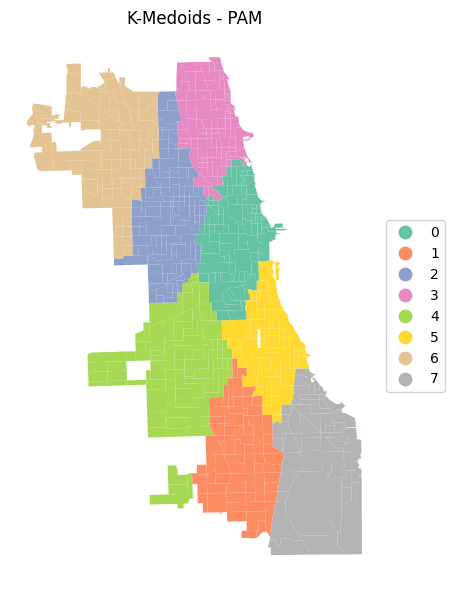

In [11]:
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                 correct=True,n_clusters=n_clusters)
cluster_map(dfs, cluster_labels, figsize=(6,6), title="K-Medoids - PAM", cmap='Set2')

The results of the various PAM algorithms are very sensitive to initial conditions as well as the implementation of the algorithm. We cannot illustrate all the permutations of starting values and algorithms, but just repeat the process with the same settings as before for `fastpam1` and `fasterpam`.

### FASTPAM1

Medoids: [464 147 565 781 334 104 386 106]
Iterations: 21
Swaps: 20
   Labels  Cardinality
0     0.0         69.0
1     1.0        129.0
2     2.0         95.0
3     3.0         87.0
4     4.0         96.0
5     5.0        110.0
6     6.0         89.0
7     7.0        116.0
Average silhouette score: 0.3543

Total Sum of Squares (TSS): 1579.9999999999995
Within-cluster Sum of Squares (WSS) for each cluster: [21.866 24.28  26.611 32.199 34.109 19.637 13.454 22.884]
Total Within-cluster Sum of Squares (WSS): 195.041
Between-cluster Sum of Squares (BSS): 1384.959
Ratio of BSS to TSS: 0.877


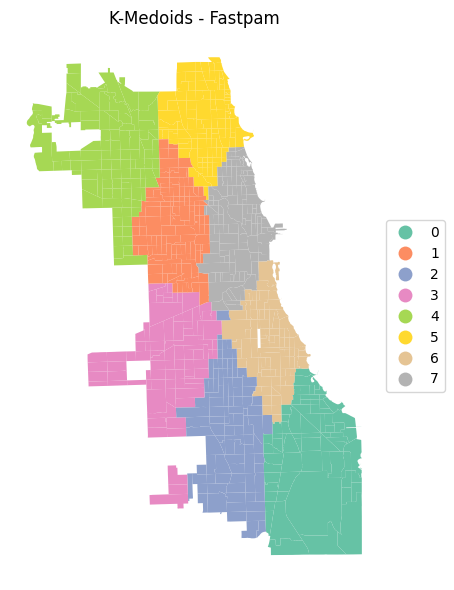

In [12]:
kmedoids_instance2 = kmedoids.fastpam1(dist_X, n_clusters,
                            random_state=1234567)
cluster_labels2 = kmedoids_instance2.labels
print("Medoids:", kmedoids_instance2.medoids)
print("Iterations:", kmedoids_instance2.n_iter)
print("Swaps:", kmedoids_instance2.n_swap)
print(cluster_stats(cluster_labels2))

sil = kmedoids.silhouette(dist_X, cluster_labels2, samples=False)
print("Average silhouette score:", round(sil[0],4))

clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels2,
                 correct=True,n_clusters=n_clusters)
cluster_map(dfs, cluster_labels2, figsize=(6,6), title="K-Medoids - Fastpam", cmap='Set2')

The results differ slightly, with a marginally worse silhouetter score (0.3543 vs 0.3538), different medoid centers and a slightly altered cluster map.

### FASTERPAM

Medoids: [464 172 334 753 148 440 219 106]
Iterations: 4
Swaps: 44
   Labels  Cardinality
0     0.0         62.0
1     1.0        127.0
2     2.0         93.0
3     3.0        103.0
4     4.0         73.0
5     5.0         99.0
6     6.0        123.0
7     7.0        111.0
Average silhouette score: 0.3561

Total Sum of Squares (TSS): 1579.9999999999995
Within-cluster Sum of Squares (WSS) for each cluster: [16.961 24.743 32.061 43.953 17.052 17.823 23.701 20.91 ]
Total Within-cluster Sum of Squares (WSS): 197.204
Between-cluster Sum of Squares (BSS): 1382.796
Ratio of BSS to TSS: 0.875


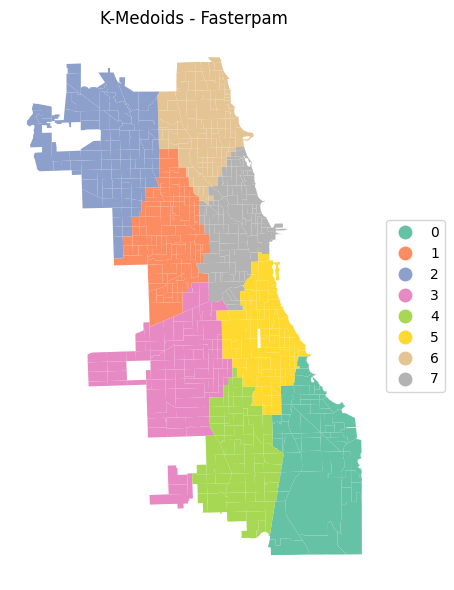

In [13]:
kmedoids_instance3 = kmedoids.fasterpam(dist_X, n_clusters,
                            random_state=1234567)
cluster_labels3 = kmedoids_instance3.labels
print("Medoids:", kmedoids_instance3.medoids)
print("Iterations:", kmedoids_instance3.n_iter)
print("Swaps:", kmedoids_instance3.n_swap)
print(cluster_stats(cluster_labels3))

sil = kmedoids.silhouette(dist_X, cluster_labels3, samples=False)
print("Average silhouette score:", round(sil[0],4))

clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels3,
                 correct=True,n_clusters=n_clusters)
cluster_map(dfs, cluster_labels3, figsize=(6,6), title="K-Medoids - Fasterpam", cmap='Set2')

### Using Actual Coordinates

The standardization of the x-y coordinates induces a compression of the distances in the largest direction. Since both standardized variables have a variance of 1, this will yield a different transformation of actual distances when the horizontal and vertical dimension of the map are not the same. This is clearly not the case in Chicago, with a much longer vertical than horizontal dimension. Therefore, it is recommended to *not* standardize coordinates when the goal is to use actual geographical distances. This is further illustrated in our discussion of spatialized cluster methods in a later notebook.

To illustrate the effect of this, we re-run the analysis for untransformed coordinates.

Medoids: [772 488 654 753 353 516 205 437]
Iterations: 10
Swaps: 9
   Labels  Cardinality
0     0.0        114.0
1     1.0         97.0
2     2.0         88.0
3     3.0        105.0
4     4.0        105.0
5     5.0         64.0
6     6.0        133.0
7     7.0         85.0
Average silhouette score: 0.3565

Total Sum of Squares (TSS): 1579.9999999999995
Within-cluster Sum of Squares (WSS) for each cluster: [30.176 35.784 16.016 45.859 41.827 40.086 29.556 16.952]
Total Within-cluster Sum of Squares (WSS): 256.256
Between-cluster Sum of Squares (BSS): 1323.744
Ratio of BSS to TSS: 0.838


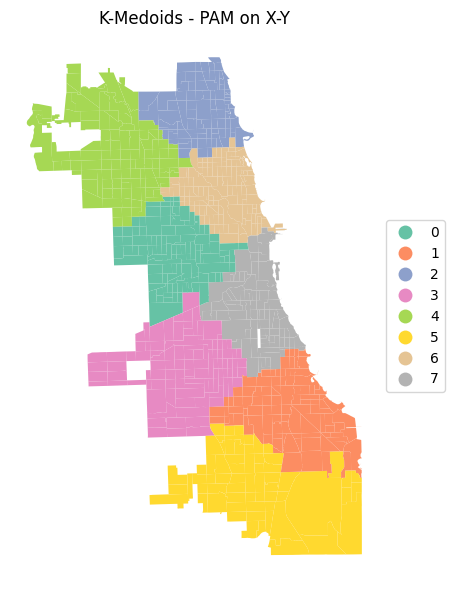

In [14]:
dist_X = pairwise_distances(data_cluster,metric='manhattan')

kmedoids_instance4 = kmedoids.pam(dist_X, n_clusters,
                            random_state=1234567)
cluster_labels4 = kmedoids_instance4.labels
print("Medoids:", kmedoids_instance4.medoids)
print("Iterations:", kmedoids_instance4.n_iter)
print("Swaps:", kmedoids_instance4.n_swap)
print(cluster_stats(cluster_labels4))

sil = kmedoids.silhouette(dist_X, cluster_labels4, samples=False)
print("Average silhouette score:", round(sil[0],4))

clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels4,
                 correct=True,n_clusters=n_clusters)
cluster_map(dfs, cluster_labels4, figsize=(6,6), title="K-Medoids - PAM on X-Y", cmap='Set2')

In the cluster map, note how the resulting regions are less elongated in the vertical direction. This is a direct result of using actual distances instead of the transformed values.